<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [17]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import misc

In [2]:
def poisson(data, event):
    mean = np.mean(data)
    return np.exp(-mean)*(mean**event)/sp.misc.factorial(event)

# Setting Up the Input Voltage

In [3]:
volt_top = np.array([1.2, 1.246, 1.303, 1.352, 1.402, 1.421, 1.440, 1.460, 1.482, 1.500, 
           1.520, 1.540, 1.562, 1.579, 1.599, 1.652, 1.701, 1.429])
counts_top = np.array([225, 367, 632, 722, 837, 935, 941, 1097, 1293, 1363, 1515, 1646, 1724,
             1936, 2131, 2497, 2798, 949])

volt_bot = np.array([1.196, 1.244, 1.267, 1.298, 1.326, 1.359, 1.393, 1.438, 1.216, 1.231, 
                     1.156, 1.102])
counts_bot = np.array([787, 1032, 1143, 1448, 1615, 1982, 2096, 2570, 882, 931, 699, 443])


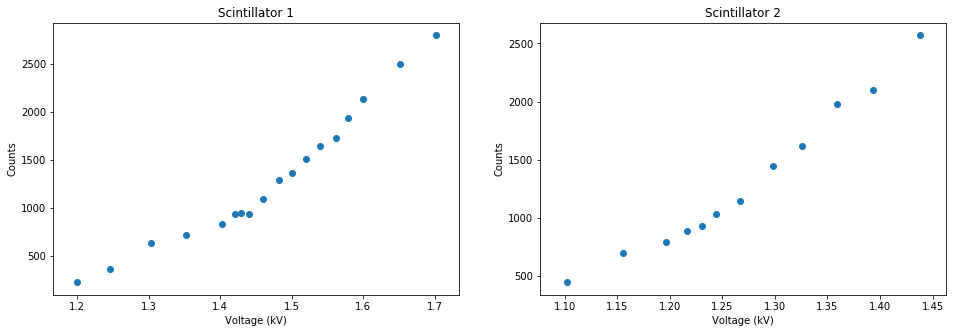

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

axes[0].scatter(volt_top, counts_top)
axes[0].set_xlabel('Voltage (kV)')
axes[0].set_ylabel('Counts')
axes[0].set_title('Scintillator 1')

axes[1].scatter(volt_bot, counts_bot)
axes[1].set_xlabel('Voltage (kV)')
axes[1].set_ylabel('Counts')
axes[1].set_title('Scintillator 2')

plt.show()

# Counting Data

## 3 Count Interval Bottom Scintillator 1.23V

Open data:

In [5]:
df = pd.read_csv('radioactive sources/', skiprows=12, names=['counts'])

Get Distributions:

In [6]:
counts = df['counts'][0:315].astype(int)
data = np.array(counts)

events = np.arange(0,9,1)
distrib = poisson(data, events) 

Plotting:

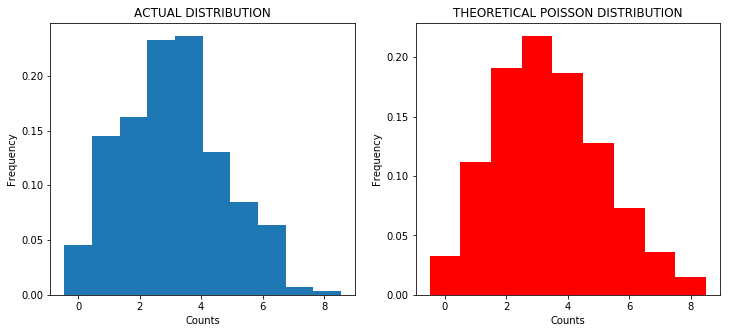

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

counts.plot.hist(ax=ax[0], density=True, align='left')
ax[1].bar(events, distrib, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Frequency')

ax[0].set_title('ACTUAL DISTRIBUTION')
ax[1].set_title('THEORETICAL POISSON DISTRIBUTION')

plt.show()

## 50 Counts Bottom Scintillator 1.23V

In [8]:
df = pd.read_csv('test2.txt', skiprows=12, names=['counts'])

In [9]:
counts = df['counts'][0:305].astype(int)
data = np.array(counts)

events = np.arange(min(counts)-10,max(counts)+10,1)
distrib = poisson(data, events) 

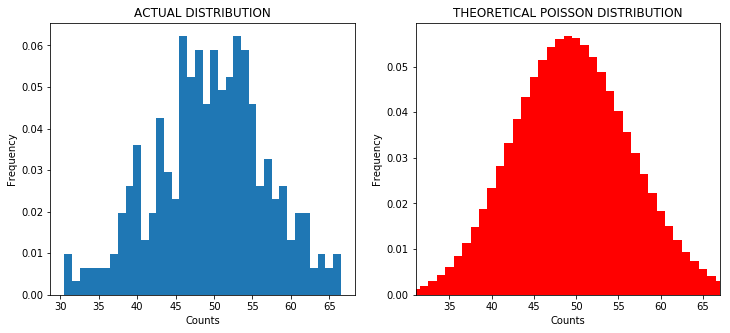

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

counts.plot.hist(ax=ax[0], density=True, align='left', bins=max(counts)-min(counts))
ax[1].bar(events, distrib, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Frequency')

ax[0].set_title('ACTUAL DISTRIBUTION')
ax[1].set_title('THEORETICAL POISSON DISTRIBUTION')
ax[1].set_xlim(min(counts), max(counts))

plt.show()

## 3 Count Interval Both Scintillators Top 1.43V Bot 1.23V

In [11]:
df = pd.read_csv('in_sync_3.txt', skiprows=12, names=['counts'])

In [12]:
counts = df['counts'][0:305].astype(int)
data = np.array(counts)

events = np.arange(min(counts),max(counts),1)
distrib = poisson(data, events) 

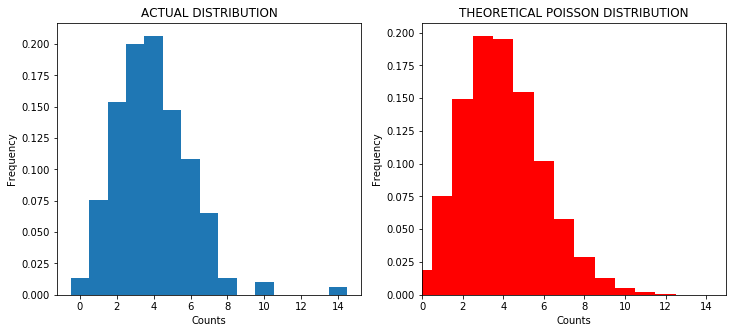

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

counts.plot.hist(ax=ax[0], density=True, align='left', bins=max(counts)-min(counts))
ax[1].bar(events, distrib, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Frequency')

ax[0].set_title('ACTUAL DISTRIBUTION')
ax[1].set_title('THEORETICAL POISSON DISTRIBUTION')
ax[1].set_xlim(min(counts), max(counts))

plt.show()

## 50 Count Interval Both Scintillators Top 1.43V Bot 1.23V

In [14]:
df = pd.read_csv('in_sync_50.txt', skiprows=12, names=['counts'])

In [15]:
counts = df['counts'][0:305].astype(int)
data = np.array(counts)

events = np.arange(min(counts),max(counts),1)
distrib = poisson(data, events) 

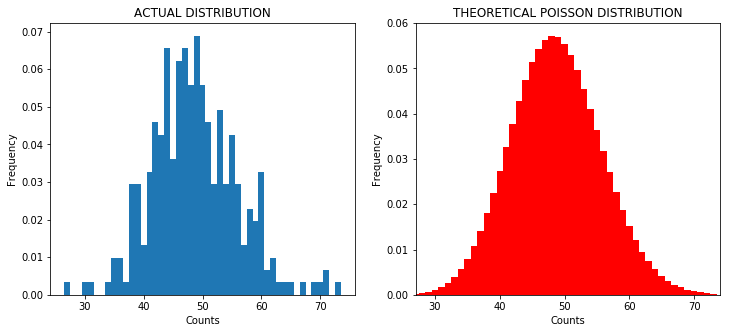

In [16]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

counts.plot.hist(ax=ax[0], density=True, align='left', bins=max(counts)-min(counts))
ax[1].bar(events, distrib, width=1, color='r')

ax[0].set_xlabel('Counts')
ax[1].set_xlabel('Counts')
ax[1].set_ylabel('Frequency')

ax[0].set_title('ACTUAL DISTRIBUTION')
ax[1].set_title('THEORETICAL POISSON DISTRIBUTION')
ax[1].set_xlim(min(counts), max(counts))

plt.show()